In [1]:
!pip install mysql-connector-python

In [27]:
#importing matplot
import matplotlib.pyplot as plt 

#importing numpy
import numpy as np 

# Set plot space as inline for inline plots display
%matplotlib inline

In [28]:
# importing pandas into jupyter notebook
import pandas as pd
#importing SQL connector
import mysql.connector

con = mysql.connector.connect(user='hbs-student', password='super-secure-password?',
                              host='hbs-ds-060120.c1doesqrid0e.us-east-1.rds.amazonaws.com',
                              database='movies')

In [29]:
#importing Box office database
# box_m = pd.read_sql_query('select * from bom_movie_gross', con)
df = pd.read_sql_query("""
                         SELECT  title, studio, bom_movie_gross.domestic_gross, 
                                 foreign_gross, year, tconst, runtime_minutes, genres, 
                                 averagerating, numvotes, directors, writers, production_budget
                         FROM movies.bom_movie_gross
                         JOIN imdb_title_basics
                         ON title = primary_title
                         JOIN imdb_title_ratings
                         USING (tconst)
                         JOIN imdb_title_crew
                         USING (tconst)
                         JOIN tn_movie_budgets
                         ON title = movie;
                         """, con)


In [14]:
df.head()

,title,studio,domestic_gross,foreign_gross,year,tconst,runtime_minutes,genres,averagerating,numvotes,directors,writers,production_budget,total_gross,ROI
0,Toy Story 3,BV,415000000,652000000,2010,tt0435761,103.0,"Adventure,Animation,Comedy",8.3,682218,nm0881279,"nm0005124,nm0004056,nm0881279,nm1578335",200000000,1067000000,4.335000
1,Inception,WB,292600000,535700000,2010,tt1375666,148.0,"Action,Adventure,Sci-Fi",8.8,1841066,nm0634240,nm0634240,160000000,828300000,4.176875
2,Shrek Forever After,P/DW,238700000,513900000,2010,tt0892791,93.0,"Adventure,Animation,Comedy",6.3,167532,nm0593610,"nm0825308,nm0458441,nm0501359,nm0011470,nm0254...",165000000,752600000,3.561212
3,The Twilight Saga: Eclipse,Sum.,300500000,398000000,2010,tt1325004,124.0,"Adventure,Drama,Fantasy",5.0,211733,nm1720541,"nm0742279,nm2769412",68000000,698500000,9.272059
4,Iron Man 2,Par.,312400000,311500000,2010,tt1228705,124.0,"Action,Adventure,Sci-Fi",7.0,657690,nm0269463,"nm0857620,nm0498278,nm1411347,nm1293367,nm0456158",170000000,623900000,2.670000


# Data cleaning

In [30]:
# Clean data
# creating total gross column
df["total_gross"]= df['domestic_gross'] + df['foreign_gross']
# cleaning production budget into integers
df['production_budget'] = df['production_budget'].str.replace(',', '')
df['production_budget'] = df['production_budget'].str.replace('$', '')
df['production_budget'] = df['production_budget'].astype(int)
# creating ROI column
df["ROI"]= (df['total_gross'] / df['production_budget']) -1
# removing empty cells
df['total_gross'].replace('', np.nan, inplace=True)
df.dropna(subset=['total_gross'], inplace=True)
# converting columns to integer
df['total_gross'] = df['total_gross'].astype(int)
df['domestic_gross'] = df['domestic_gross'].astype(int)
df['foreign_gross'] = df['foreign_gross'].astype(int)

# Analysis of most successfull genres by revenue and IMDB ratings 2012

In [31]:
# Import formatting packages
import seaborn as sns
import scipy.stats as st
import math
from statistics import mean, stdev
from math import sqrt
from scipy.stats import ttest_ind
plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'retina'
sns.set(style="whitegrid")

In [32]:
# Data cleansing and formatting
# Movies with bottom 25% of # votes will be excluded as these are less known and could skew the results
highly_rated_movies = df[df.numvotes >1.298000e+04]
highly_rated_movies = highly_rated_movies[highly_rated_movies.year == 2012]

# Averages are being calculated for genres that contatin multiple movies
highly_rated_movies["rating_helper_column"] = highly_rated_movies.apply(lambda row: row.year / 2012 ,axis=1)
highly_rated_movies = highly_rated_movies.groupby('genres').sum()
highly_rated_movies["year"] = highly_rated_movies.apply(lambda row: row.year / row.rating_helper_column ,axis=1)
highly_rated_movies["averagerating"] = highly_rated_movies.apply(lambda row: row.averagerating / row.rating_helper_column ,axis=1)
highly_rated_movies["runtime_minutes"] = highly_rated_movies.apply(lambda row: row.runtime_minutes / row.rating_helper_column ,axis=1)
highly_rated_movies["ROI"] = highly_rated_movies.apply(lambda row: row.ROI / row.rating_helper_column ,axis=1)

# Total_gross revenue is being converted to bn USD
highly_rated_movies["total_gross"] = highly_rated_movies.apply(lambda row: row.total_gross / 1000000000 ,axis=1)


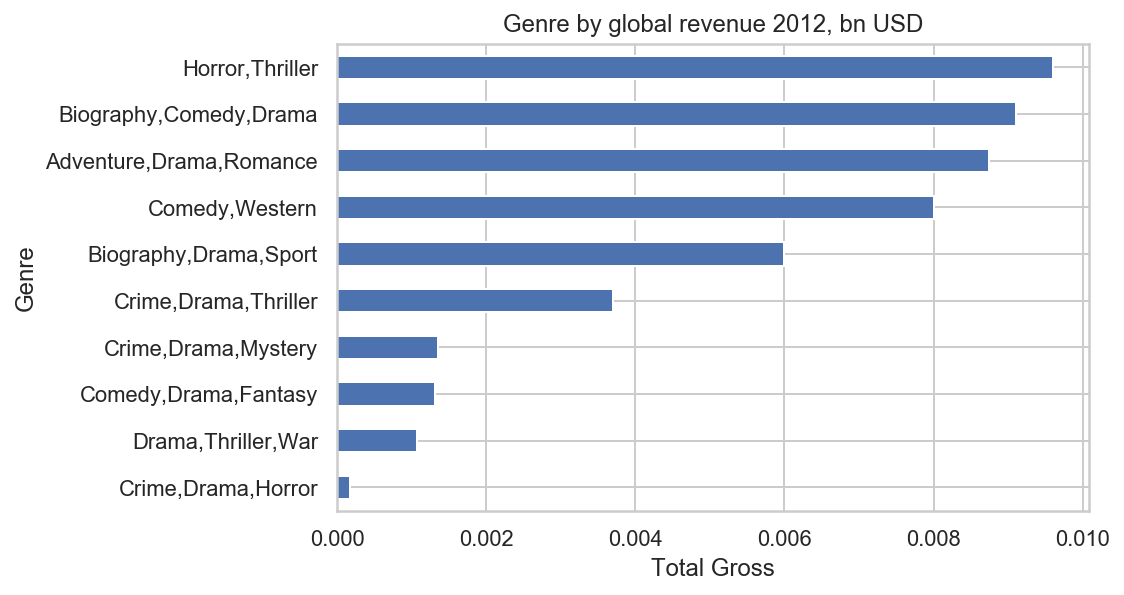

In [30]:
# Plot top 10 genres by revenue 
popular_movies = highly_rated_movies.total_gross.sort_values(ascending=True)
popular_movies = popular_movies.head(10)
popular_movies.plot(x='genres', y = ['total_gross'], kind = 'barh', color='b')
plt.title("Genre by global revenue 2012, bn USD")
plt.ylabel("Genre")
plt.xlabel("Total Gross")
plt.show()

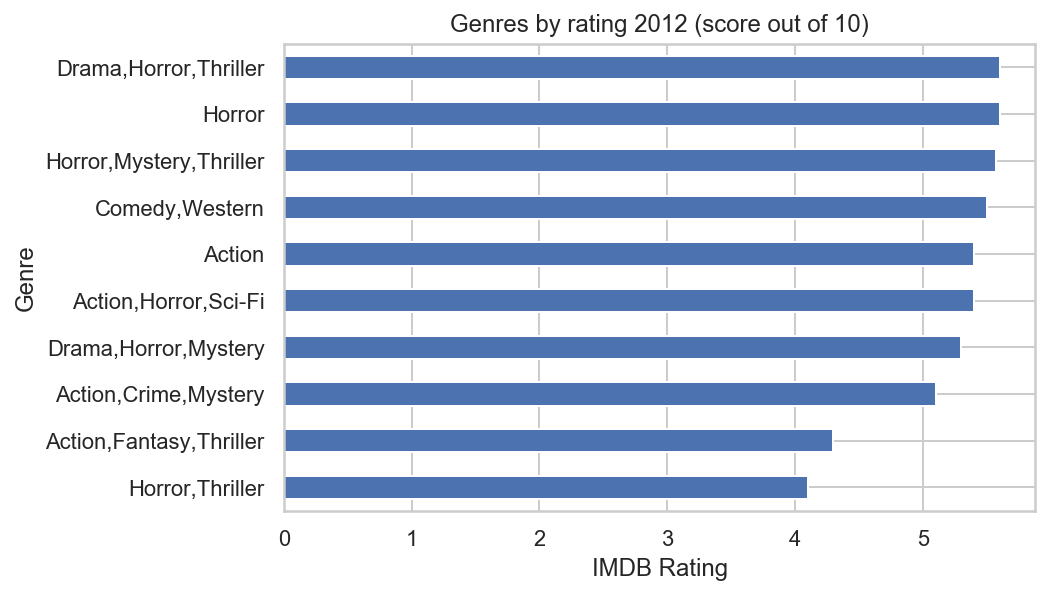

In [31]:
# Plot top 10 genres by ratings 
highly_rated = highly_rated_movies.averagerating.sort_values(ascending=True)
highly_rated = highly_rated.head(10)
highly_rated.plot(x='genres', y = ['averagerating'], kind = 'barh', color='b')
plt.title("Genres by rating 2012 (score out of 10)")
plt.ylabel("Genre")
plt.xlabel("IMDB Rating")
plt.show()

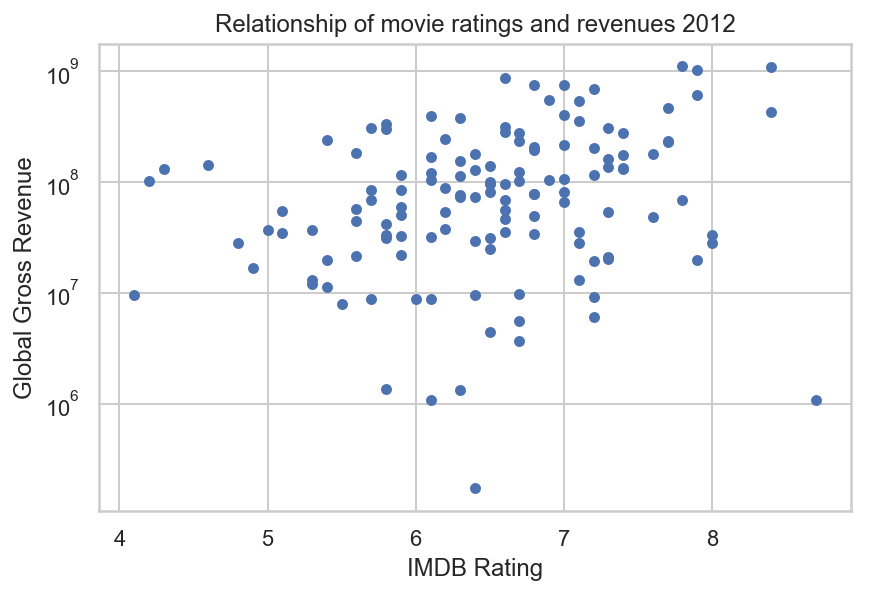

Ttest_indResult(statistic=8.328845045819119, pvalue=4.4779038224305236e-15)

In [22]:
# Plot relationship of ratings and gross revenues 2012
popularity_revenue_relationship = df[df.year == 2012]
popularity_revenue_relationship.plot(x='averagerating', y = ['total_gross'], kind = 'scatter',logy=True, color='b')
plt.title("Relationship of movie ratings and revenues 2012")
plt.xlabel("IMDB Rating")
plt.ylabel("Global Gross Revenue")
plt.show()

# Statistical relevance test of relationships
from scipy.stats import ttest_ind
ttest_ind(popularity_revenue_relationship['total_gross'], popularity_revenue_relationship['averagerating'])

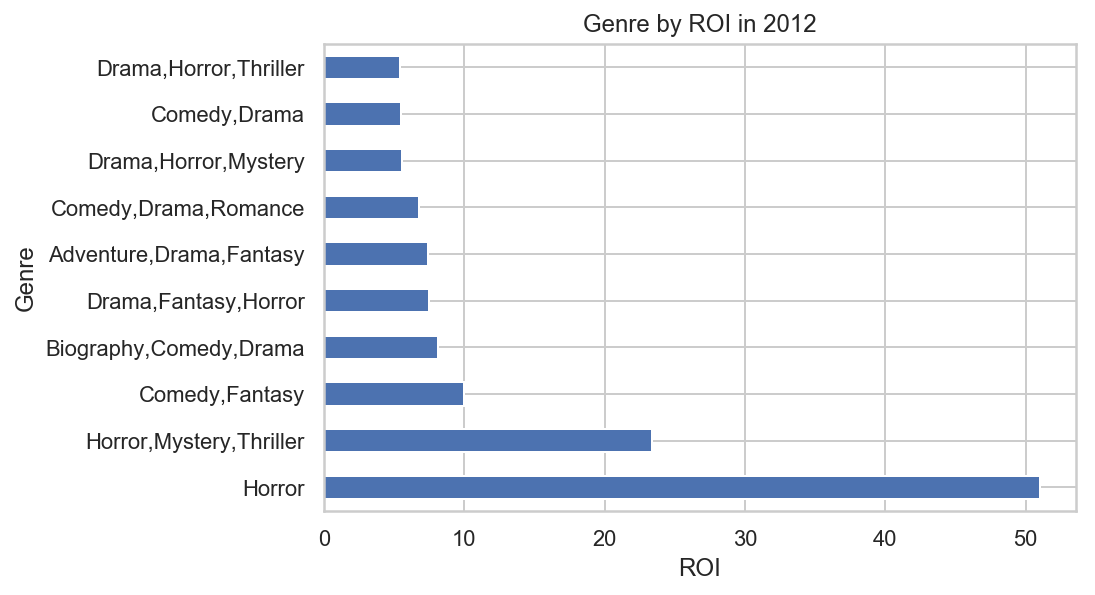

In [35]:
# Plot top 10 genres by ROI 
popular_movies = highly_rated_movies.ROI.sort_values(ascending=False)
popular_movies = popular_movies.head(10)
popular_movies.plot(x='genres', y = ['ROI'], kind = 'barh', color='b')
plt.title("Genre by ROI in 2012")
plt.ylabel("Genre")
plt.xlabel("ROI")
plt.show()

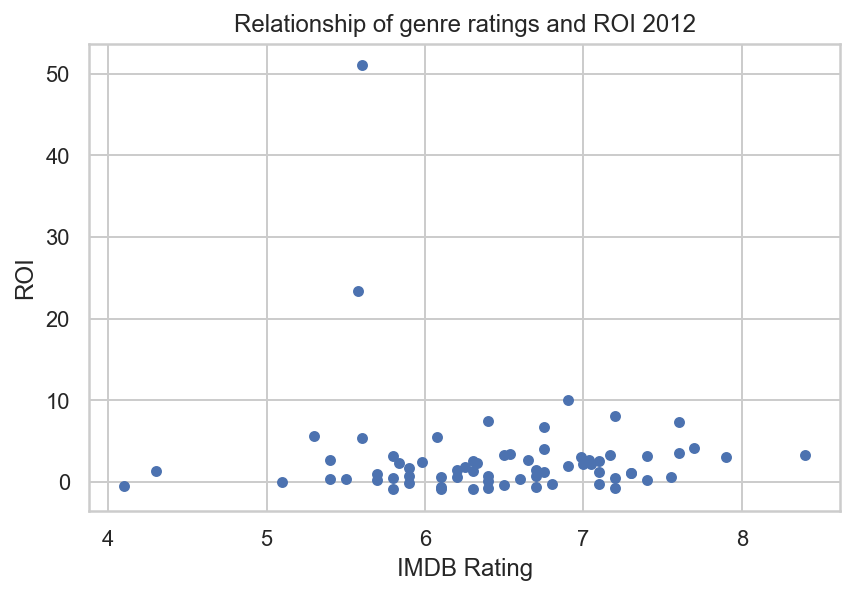

Ttest_indResult(statistic=-4.2522323474025265, pvalue=3.8776393915799525e-05)

In [13]:
# Plot relationship of ratings and gross revenues 2012
highly_rated_movies.plot(x='averagerating', y = ['ROI'], kind = 'scatter', color='b')
plt.title("Relationship of genre ratings and ROI 2012")
plt.xlabel("IMDB Rating")
plt.ylabel("ROI")
plt.show()

# Statistical relevance test of relationships
from scipy.stats import ttest_ind
ttest_ind(highly_rated_movies['ROI'], highly_rated_movies['averagerating'])

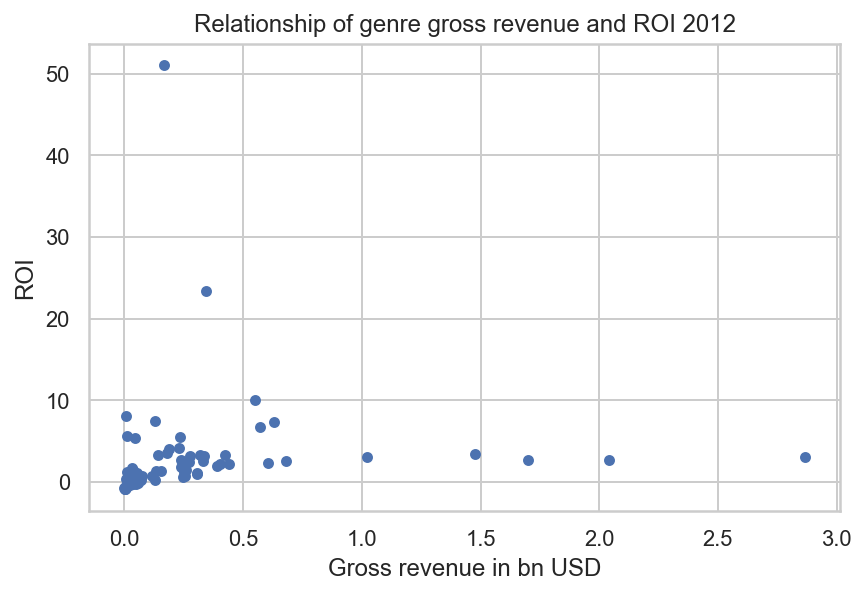

Ttest_indResult(statistic=3.3299151981820034, pvalue=0.0011144549238387696)
-0.5628583995257342


In [45]:
# Plot relationship of gross revenues and ROI 2012
highly_rated_movies.plot(x='total_gross', y = ['ROI'], kind = 'scatter', color='b')
plt.title("Relationship of genre gross revenue and ROI 2012")
plt.xlabel("Gross revenue in bn USD")
plt.ylabel("ROI")
plt.show()

# Statistical relevance test of relationships
print(ttest_ind(highly_rated_movies['ROI'], highly_rated_movies['total_gross']))

# Effect size
cohens_d = (mean(highly_rated_movies.total_gross) - mean(highly_rated_movies.ROI)) / (sqrt((stdev(highly_rated_movies.total_gross) ** 2 + stdev(highly_rated_movies.ROI) ** 2) / 2))
print(cohens_d)

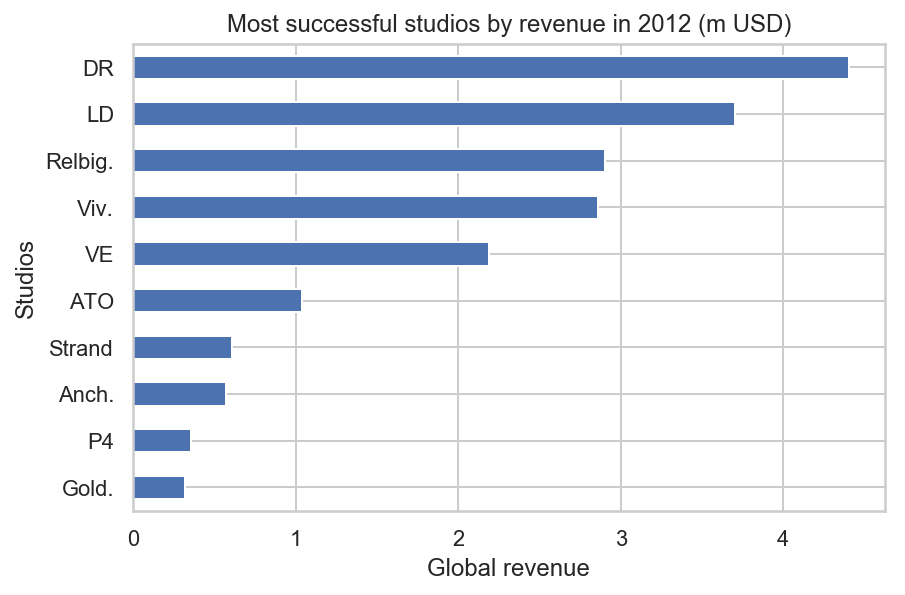

In [33]:
# 10 highest grossing studios to partner with

# Total_gross revenue is being converted to m USD
best_studios = df
best_studios["total_gross"] = best_studios.apply(lambda row: row.total_gross / 1000000 ,axis=1)

# Anaylysing 10 highest grossing studios to partner with
best_studios = df.groupby('studio').sum().sort_values("total_gross").total_gross.head(10)

# Plot highest grossing studios in m USD
best_studios.plot(x='studios', y = ['total_gross'], kind = 'barh', color='b')
plt.title("Most successful studios by revenue in 2012 (m USD)")
plt.xlabel("Global revenue")
plt.ylabel("Studios")
plt.show()